In [221]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         73G         37G         48M         15G         50G
Swap:           15G         29M         15G


In [9]:
#allows to reload modules properly
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys, os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import seaborn as sns
import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray
import os
os.sys.path.append('../../')
import eda_tools
from eda_tools import nicole_tools as nt
from eda_tools import histogram_helper as hh
from eda_tools import utilities as u
from eda_tools import trigger_utilities as tu
from eda_tools import plot_helper as ph
from eda_tools import pyhf_models as pm
from loadNNT import loadNNT
from math import log10
from hepstats.modeling import bayesian_blocks
import pyhf
from pyhf import Model, optimizer
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.backend as K

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers.normalization import BatchNormalization
from eda_tools import NN_RW as nn

In [12]:
from eda_tools import bkg_helper as bh

In [13]:
from scipy.stats import norm as normG
import matplotlib.mlab as mlab

In [14]:
!ls -lh /mnt/storage/lborgna/

total 95G
-rw-r--r-- 1 lborgna users 113M Feb 20 15:32 B1d.pkl
-rw-r--r-- 1 lborgna users  74M Feb 20 15:31 B1s.pkl
-rw-r--r-- 1 lborgna users 300M Feb 25 00:16 B2_BDT_weights100.npz
-rw-r--r-- 1 lborgna users 2.6M Feb 24 23:06 B2_BDT_weights1.npz
-rw-r--r-- 1 lborgna users 1.5G Feb 20 15:32 B2d.pkl
-rw-r--r-- 1 lborgna users 123M Feb 20 15:31 B2s.pkl
-rw-r--r-- 1 lborgna users 1.2G Feb 20 15:32 B3d.pkl
-rw-r--r-- 1 lborgna users 267M Feb 25 23:16 B3_NN_100.npz
-rw-r--r-- 1 lborgna users  29M Feb 20 15:31 B3s.pkl
-rw-r--r-- 1 lborgna users 5.9G Feb 20 15:33 B4d.pkl
-rw-r--r-- 1 lborgna users  28M Feb 20 15:31 B4s.pkl
-rw-r--r-- 1 lborgna users  69M Dec 16 15:46 BDT18_d2b2j_CR
-rw-r--r-- 1 lborgna users  89M Dec 16 15:44 BDT18_d2b2j_SB
-rw-r--r-- 1 lborgna users  18M Dec 16 15:51 BDT18_dother_CR
-rw-r--r-- 1 lborgna users  33M Dec 16 15:51 BDT18_dother_SB
-rw-r--r-- 1 lborgna users 120K Mar  3 00:35 bucket1_BDT_weights
drwxr-xr-x 5 lborgna users 4.0K Mar  3 01:56 condaenv
-rw-r--r-- 1 l

In [19]:
df = pd.read_pickle('/mnt/storage/lborgna/data18.pkl')

In [20]:
df.columns

Index(['triggerMap', 'eventNumber', 'runNumber', 'run_number', 'event_number',
       'mc_sf', 'ntag', 'njets', 'kinematic_region', 'pairing_score_1',
       'pairing_score_2', 'm_hh', 'pt_hh', 'X_wt', 'm_h1', 'E_h1', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h2', 'E_h2', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h1_j1', 'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1',
       'angle_h1_j1', 'm_h1_j2', 'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2',
       'phi_h1_j2', 'tag_h1_j2', 'angle_h1_j2', 'm_h2_j1', 'E_h2_j1',
       'pT_h2_j1', 'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1', 'angle_h2_j1',
       'm_h2_j2', 'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2',
       'BDT_d24_weight_18', 'BDT_d24_weight_CRderiv', 'HT', 'm_hh_cor'],
      dtype='object')

In [24]:
u.calculatedPhi(df)
u.calculatedRhh(df)

In [28]:
rw_cols_to_log = ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2','pt_hh','X_wt']

In [29]:
rw_cols_log = ['pT_2_log', 'pT_4_log', 'eta_i', 'dRjj_1_log','dRjj_2_log','njets','pt_hh_log','X_wt_log','dR_hh','dPhi_h1','dPhi_h2']

In [30]:
nn.log_inputs(df, to_log = rw_cols_to_log)

In [31]:
def NN(in_shape, size = 20, batch_norm = True):
    inputs = Input(shape = (in_shape[1],))
    hidden = Dense(size, activation = 'relu')(inputs)

    if batch_norm:
        hidden = BatchNormalization()(hidden)
    hidden = Dense(size, activation = 'relu')(hidden)
    if batch_norm:
        hidden = BatchNormalization()(hidden)
    hidden = Dense(size, activation = 'relu')(hidden)
    if batch_norm:
        hidden = BatchNormalization()(hidden)
    outputs = Dense(1, activation = 'linear')(hidden)

    model = Model(inputs, outputs)

    return model

Let's Try and train 1 single bootstrap with the poissonian weights

First let's extract the kinematic region we want to train on, for simplicity let's say its the CR

In [33]:
CR = df[df.kinematic_region == 2]

In [51]:
CR.reset_index(drop= True, inplace = True)

In [52]:
#generate poissonian weights

In [53]:
poisson_weights = np.random.poisson(1, len(CR))

In [141]:
X_train.shape[0]

3160171

In [142]:
len(CR)

3453514

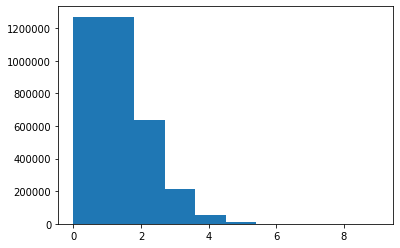

In [54]:
_,_,_ = plt.hist(poisson_weights, bins = 10)

In [57]:
CR['poisson_weight'] = poisson_weights

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [227]:
df.loc[df.kinematic_region == 2, 'poisson_Weight'] = poisson_weights

In [229]:
df['poisson_Weight']

0           NaN
1           NaN
2           2.0
3           2.0
4           0.0
           ... 
17484146    NaN
17484147    1.0
17484148    NaN
17484149    NaN
17484150    NaN
Name: poisson_Weight, Length: 17484151, dtype: float64

In [58]:
CR['poisson_weight']

0          2
1          2
2          0
3          0
4          1
          ..
3453509    0
3453510    0
3453511    1
3453512    0
3453513    1
Name: poisson_weight, Length: 3453514, dtype: int64

In [63]:
original = CR[CR.ntag == 2][rw_cols_log]
original.reset_index(drop=True, inplace = True)
original.head()

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log  njets  pt_hh_log  \
0  4.974046  4.380039  0.546362   -0.042786    0.114881      4   4.383296   
1  4.274890  3.930711  0.869075    0.363238    0.734763      4   3.147058   
2  4.696404  4.264678  0.929509   -0.116108   -0.023172      4   2.032747   
3  4.549931  3.900043  0.650327   -0.186010    0.925135      4   4.544375   
4  4.398411  4.234810  1.140854    0.436794    0.521009      4   3.753499   

   X_wt_log     dR_hh   dPhi_h1   dPhi_h2  
0  1.986329  3.095367  0.942487  0.735561  
1  1.669650  3.375347  0.268804  0.297377  
2  1.653388  3.402020  0.263147  0.390596  
3  1.253331  3.224849  1.448984  2.170814  
4  1.870415  3.170191  0.048400  0.386065

In [64]:
target = CR[CR.ntag >= 4][rw_cols_log]
target.reset_index(drop=True, inplace = True)
target.head()

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log  njets  pt_hh_log  \
0  5.165255  4.175535  1.190579    0.045899    0.165046      4   4.294810   
1  4.447898  3.727301  1.005495    0.342675    0.653611      4   3.646754   
2  4.877374  4.223175  0.214437    0.246121    0.756671      4   3.822661   
3  4.906345  3.718231  1.615843   -0.423506    0.190527      5   5.385261   
4  4.459865  3.967774  1.233270   -0.096368    0.167498      5   4.757138   

   X_wt_log     dR_hh   dPhi_h1   dPhi_h2  
0  1.660613  2.950748  1.162565  0.712270  
1  0.621311  2.944343  0.522193  1.171063  
2  1.542471  3.031511  1.207759  1.707171  
3  1.191721  1.489062  1.119586  2.840456  
4  1.511288  3.049811  0.490923  0.314378

In [ ]:
#Concatenate all of the features

In [66]:
X_all = pd.concat((original, target), ignore_index=True).values

In [67]:
#Create the labels for the features

In [69]:
Y_all = []
for _df, ID in[(original, 1), (target, 0)]:
    Y_all.extend([ID] * _df.shape[0])
Y_all = np.array(Y_all)

In [70]:
#Some pre-processing

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_all)
Y_train = Y_all.copy()

In [73]:
#Shufle

In [74]:
idxs = np.random.permutation(len(X_train))
X_train = X_train[idxs]
Y_train = Y_train[idxs]


In [75]:
model = NN(X_train.shape, size = 50)

In [76]:
model.compile(loss = nn.louppe_loss, metrics = ['accuracy'], optimizer = 'adam')

In [77]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                600       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200 

In [84]:
CR.iloc[idxs]['poisson_weight'].values #This is wrong because it might include 3b events 

array([1, 3, 1, ..., 4, 0, 0])

In [85]:
original_weights = CR[CR.ntag == 2].poisson_weight

In [86]:
target_weights = CR[CR.ntag >= 4].poisson_weight

In [87]:
pW = np.concatenate((original_weights, target_weights))[idxs]

In [144]:
pW = np.random.poisson(1, X_train.shape[0])

In [145]:
len(pW)

3160171

In [146]:
history = model.fit(X_train, Y_train, sample_weight = pW,
                   callbacks = [
                       EarlyStopping(monitor='val_loss', patience = 10, verbose = True),
                       ModelCheckpoint('/mnt/storage/lborgna/test.h5', monitor = 'val_loss', verbose = True, save_best_only = True)],
                       epochs = 80,
                       validation_split = 0.4
                       batch_size = 8192
                   )

Train on 1896102 samples, validate on 1264069 samples
Epoch 1/80
1896102/1896102 [==============================] - 3s 2us/step - loss: 0.1563 - accuracy: 0.0000e+00 - val_loss: 0.1588 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.15882, saving model to /mnt/storage/lborgna/test.h5
Epoch 2/80
1896102/1896102 [==============================] - 3s 2us/step - loss: 0.1552 - accuracy: 0.0000e+00 - val_loss: 0.1589 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.15882
Epoch 3/80
1896102/1896102 [==============================] - 3s 2us/step - loss: 0.1543 - accuracy: 0.0000e+00 - val_loss: 0.1597 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.15882
Epoch 4/80
1896102/1896102 [==============================] - 3s 2us/step - loss: 0.1537 - accuracy: 0.0000e+00 - val_loss: 0.1606 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.15882
Epoch 5/80
1896102/1896102 [==============================] 

In [147]:
model.load_weights('/mnt/storage/lborgna/test.h5')

In [148]:
pred = model.predict(scaler.transform(df[df.ntag == 2][rw_cols_log].values), batch_size = 8192)

In [149]:
len(pred)

16079229

In [150]:
len(df[df.ntag==2])

16079229

In [151]:
df.loc[df.ntag==2, 'NN_weight'] = np.exp(pred)[:, 0]

In [152]:
df[df.NN_weight.isna()]['NN_weight'] = 1

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [153]:
df

triggerMap  eventNumber  \
0         {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2022680706   
1         {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2022730668   
2         {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2022677565   
3         {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2023173786   
4         {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2023465071   
...                                                     ...          ...   
17484146  {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2023429913   
17484147  {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2023569009   
17484148  {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2023743419   
17484149  {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2023551509   
17484150  {'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25'...   2023825703   

          runNumber  run_number  event_number  mc_sf  ntag  njets  \
0            362204      362204    2022680706    1.0     2      4   
1            362204      362204    2022730668    1.0     2      4   
2            362204      362204    2022677565    1.0     2      4   
3            362204      362204    2023173786    1.0     2      4   
4            362204      362204    2023465071    1.0     2      4   
...             ...         ...           ...    ...   ...    ...   
17484146     362204      362204    2023429913    1.0     2      4   
17484147     362204      362204    2023569009    1.0     2      4   
17484148     362204      362204    2023743419    1.0     2      4   
17484149     362204      362204    2023551509    1.0     2      4   
17484150     362204      362204    2023825703    1.0     2      4   

          kinematic_region  pairing_score_1  ...   dPhi_h1   dPhi_h2  \
0                        3              0.0  ...  0.672615  0.069540   
1                        3              0.0  ...  0.326817  0.574100   
2                        2              0.0  ...  0.942487  0.735561   
3                        2              0.0  ...  0.268804  0.297377   
4                        2              0.0  ...  0.263147  0.390596   
...                    ...              ...  ...       ...       ...   
17484146                 1              0.0  ...  0.025257  1.208487   
17484147                 2              0.0  ...  1.360309  0.187339   
17484148                 3              0.0  ...  1.181328  1.267883   
17484149                 0              0.0  ...  1.414618  1.774019   
17484150                 3              0.0  ...  2.017561  2.319484   

             dR_hh  pT_2_log  pT_4_log  dRjj_1_log  dRjj_2_log  pt_hh_log  \
0         3.251186  4.276540  3.789905   -0.193890    0.810487   2.071379   
1         3.186965  4.531471  3.836813   -0.249920   -0.128548   3.891905   
2         3.095367  4.974046  4.380039   -0.042786    0.114881   4.383296   
3         3.375347  4.274890  3.930711    0.363238    0.734763   3.147058   
4         3.402020  4.696404  4.264678   -0.116108   -0.023172   2.032747   
...            ...       ...       ...         ...         ...        ...   
17484146  3.439897  4.578205  3.771578    0.355606    0.513414   3.307050   
17484147  2.891081  4.634332  4.403267    0.213375    0.526139   4.226129   
17484148  3.175693  4.513829  4.035197    0.403809    0.673479   2.922986   
17484149  3.033965  4.371078  3.949062    0.186994    0.662408   3.973013   
17484150  2.932820  4.507385  4.163549   -0.196242    0.149815   4.039389   

          X_wt_log  NN_weight  
0         1.527697   0.009074  
1         0.528973   0.005253  
2         1.986329   0.006072  
3         1.669650   0.002553  
4         1.653388   0.006811  
...            ...        ...  
17484146  0.889407   0.002153  
17484147  1.844272   0.002945  
17484148  1.777956   0.002759  
17484149  0.927196   0.002781  
17484150  1.028726   0.006073  

[17484151 rows x 71 columns]

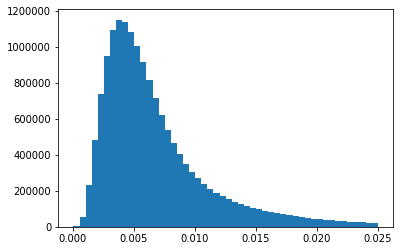

In [154]:
_,_, _ = plt.hist(df[df.ntag == 2].NN_weight, bins = 50, range = (0.00005, 0.025))

In [155]:
(df[df.ntag == 2].NN_weight == 1).value_counts()

False    16079229
Name: NN_weight, dtype: int64

In [118]:
#We also need to calculate the normalization for the bootstrap

In [240]:
N4b = 1.0*np.sum(CR[CR.ntag >=4].poisson_weight.values)

In [241]:
N4b

21197.0

In [239]:
N2b = np.sum(CR[CR.ntag == 2].poisson_weight.values * df[(df.ntag == 2) & (df.kinematic_region == 2)].NN_weight.values)

In [231]:
N2b

22462.180216167835

In [224]:
muQCD_BS = N4b/N2b

In [225]:
muQCD_BS

0.9436750928007788

## Let's try to multi-thread it

In [137]:
import multiprocessing
from multiprocessing import Pool

In [206]:
def trainNN(bs_label, config = None):
    
    
    global df
    
    global X_train
    
    global Y_train
    
    global storage
    
    global CR
    
    global rw_cols_log
    
    model_filename = storage + 'model_' + str(bs_label) +'.h5'
    
    pW = np.random.poisson(1, X_train.shape[0])
    
    model = NN(X_train.shape, size = 50)
    model.compile(loss = nn.louppe_loss, metrics = ['accuracy'], optimizer = 'adam')
    
    history = model.fit(X_train, Y_train, sample_weight = pW,
                   callbacks = [
                       EarlyStopping(monitor='val_loss', patience = 10, verbose = True),
                       ModelCheckpoint(model_filename, monitor = 'val_loss', verbose = True, save_best_only = True)],
                       epochs = 80,
                       validation_split = 0.4,
                       batch_size = 8192
                   )
    
    weight_label = 'NN_BS_' + str(bs_label)
    
    pred = model.predict(scaler.transform(df[df.ntag == 2][rw_cols_log].values), batch_size = 8192)
    
    df.loc[df.ntag==2, weight_label] = np.exp(pred)[:, 0]
    df.loc[df[weight_label].isna(), weight_label] = 1
    
    return bs_label
    


In [207]:
nbs = 100
bs_labels = np.arange(1, nbs+1)

In [208]:
len(bs_labels)


100

In [209]:
storage = '/mnt/storage/lborgna/modelbs/'

In [210]:
with Pool(32-2) as p:
    
    results = list(tqdm(p.starmap(trainNN, zip(bs_labels)), total = len(bs_labels)))

KeyboardInterrupt: 

In [211]:
results

NameError: name 'results' is not defined

In [ ]:
with Pool(njobs -2) as p:

    resultStarMap = list(tqdm_notebook(len(BucketsConfigList), p.starmap(getBucketsLimitMT, zip(BucketsConfigList))))



In [ ]:
with Pool(12) as p:

    resultsstar = list(tqdm(p.starmap(getBand, signals[0]), total = len(lambdas))

In [188]:
CRW = df[(df.ntag != 3) & (df.kinematic_region == 2)]['NN_weight'].values

In [189]:
np.sum(pW, where = Y_train == 0, axis = 0)

21350

In [194]:
t = pW*CRW

In [195]:
np.sum(t, where = Y_train == 1, axis = 0)

nan

In [179]:
df[(df.ntag == 2) & (df.kinematic_region == 2)]['NN_weight'].sum()

22439.21906559418

In [180]:
3136847*22439.21906

70388396990.70381

In [174]:
np.sum(np.exp(pred)[:,0])

116780.33

In [175]:
len(pred)

16079229

In [212]:
wi = np.random.random(1000)

In [213]:
wi

array([5.46005044e-01, 7.48290008e-01, 1.56642756e-02, 2.26368920e-01,
       1.03201459e-01, 4.96756565e-01, 6.75971421e-01, 6.38216163e-01,
       5.99693493e-02, 6.77323255e-01, 6.04400468e-01, 2.33937944e-01,
       1.40525689e-01, 5.16823039e-01, 3.01516792e-01, 2.68812463e-01,
       8.51094089e-01, 4.34030880e-02, 2.38052568e-01, 5.60498398e-01,
       9.81194773e-01, 2.23130557e-01, 3.35575745e-01, 2.38251814e-01,
       8.54036044e-01, 6.60614627e-02, 7.06223212e-01, 7.12436439e-01,
       2.80401799e-01, 1.65341457e-01, 8.82062393e-01, 2.62165084e-01,
       5.11866200e-01, 1.37966600e-01, 7.45317001e-01, 6.17730648e-01,
       6.74163230e-01, 6.65966128e-02, 5.13766777e-01, 4.02814508e-01,
       1.92186637e-01, 2.70686303e-01, 5.69052232e-01, 4.34765103e-01,
       8.45882407e-01, 1.45805756e-01, 6.52472442e-01, 8.48543648e-01,
       4.92450200e-01, 4.97571143e-01, 3.85769865e-01, 4.68396811e-02,
       8.16098527e-01, 9.08006714e-01, 6.45827078e-01, 7.61450217e-02,
      

In [214]:
wp = np.random.random(1000)

In [216]:
np.sum(wi*wp)

249.05339469834485

In [220]:
np.sum(wi)*np.sum(wp)

251373.66820801675